# Calculate Compound Years for CESM

This file grabs the warm season indeces and sees if this shows us anything


You need to run cesmIndeces.ipnyb first

In [13]:
#For plots of a single experiment to demonstrate things, plot this one:

expToPlot = 'LME.002'

In [14]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
from utils.timePeriod import averageForTimePeriod

%run 'utils/compound.ipynb'

In [15]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas

%matplotlib inline

In [16]:
# Here is the data
indecesDa = xarray.load_dataarray('results/cesmTradIndeces.nc')

indecesDa.experiment.values

array(['LME.002', 'LME.003', 'LME.008', 'LME.009', '001', '002', '003',
       '004', '005', '006', '007', '008', '009', '010', '011', '012',
       '013'], dtype=object)

# Define a criteria to determine events, and plot an example

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

For now, using a 850-1850 climatology

In [17]:
# This should calculate stds for all experiments and all indeces
stdDa = indecesDa.std(dim='year')

# define some criteria that we want to use to identifiy it thats an event
criteriaDa = xarray.concat(
    (stdDa.sel(index=['nino34','dmi']), stdDa.sel(index='sam')/2),
    'index'
)

# Calculate the compounding years and plot an example

In [18]:
firePos, fireNeg = applyCriteria(indecesDa, criteriaDa)

firePos=compound(firePos)

fireNeg=compound(fireNeg)

Text(0.5, 1.0, 'LME.002: Pairs and all-three compounds for individal years')

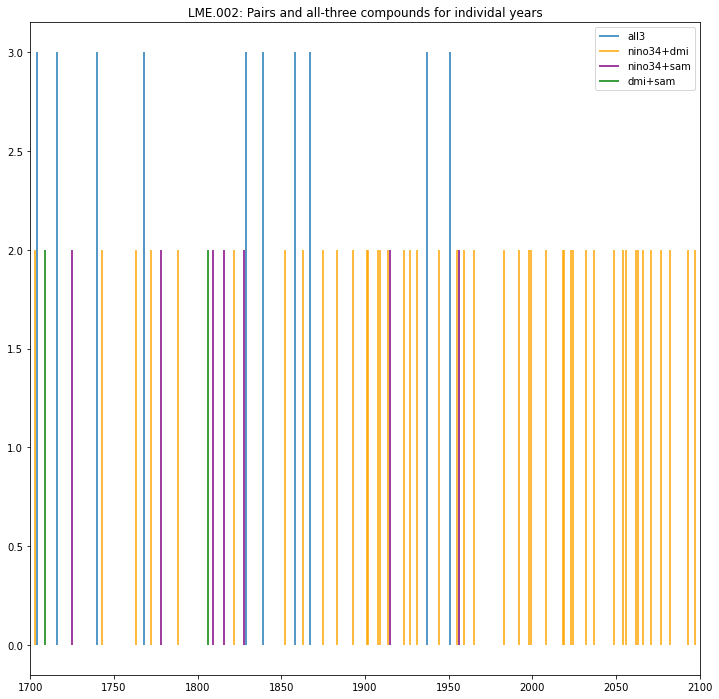

In [19]:

toPlot=3*firePos.sel(experiment=expToPlot, index='all3')

plt.figure(figsize=(12,12))

plt.vlines(
    x=firePos.year, 
    ymin=0,
    ymax=toPlot,
    label='all3'
)

colors=['orange', 'purple', 'green']
iCol = 0

for iPair in firePos.attrs['pairs']:
    plt.vlines(
        x=firePos.year, 
        ymin=0,
        ymax=2*firePos.sel(experiment=expToPlot, index=iPair),
        color=colors[iCol],
        label=iPair
    )
    iCol+=1
plt.legend()
plt.xlim(1700,2100)
plt.title(expToPlot+': Pairs and all-three compounds for individal years')

# In non-overlapping 30 year bins

Calculate non-overlapping 30 year bins, and sum the number of events in them

In [20]:
yearBins=numpy.arange(860, 2100, 30)

binMid=numpy.arange(875, 2086, 30)

binnedFirePos=firePos.groupby_bins('year', yearBins, labels=binMid ).sum() 

binnedFirePos= binnedFirePos.rename({'year_bins':'year'})


Plot the mean in each bin for the full forcing ensemble and the rcp85 extensions

In [21]:
pairs=firePos.attrs['pairs']
toPlot=[*pairs,'all3']
colors=['orange', 'purple', 'green','blue']

def binPlot(da, expSet):

    plt.figure(figsize=(18,10))

    for counter in [0,1,2,3]:
        plt.vlines(
            x=da.year-3+1.5*counter, 
            ymin=0,
            ymax=da.sel(index=toPlot[counter], experiment=expSet).mean(dim='experiment'),
            label=toPlot[counter],
            color=colors[counter]
        )

    plt.legend(loc='upper left')
    plt.xticks(ticks=da.year)
    plt.xlim(1700,2100)
    plt.xlabel('Mid-point of 30 year bin')
    plt.ylim(0,8)
    plt.ylabel('Number of events (mean)')
    plt.title('Pairs and all-three for runs with ' + str(expSet) + ', in non-overlaping 30 year bins')
    plt.minorticks_on()

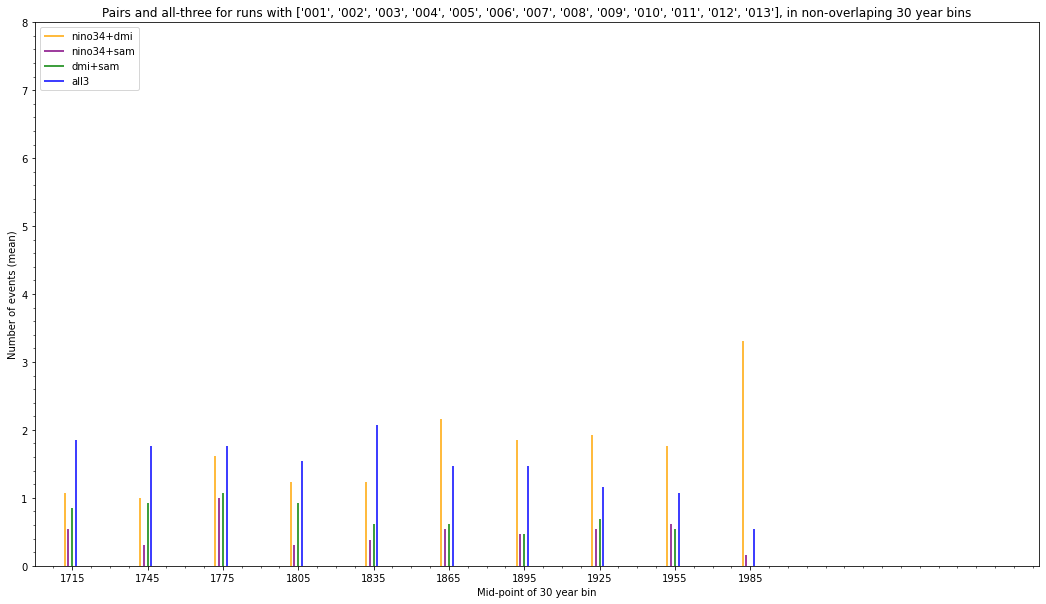

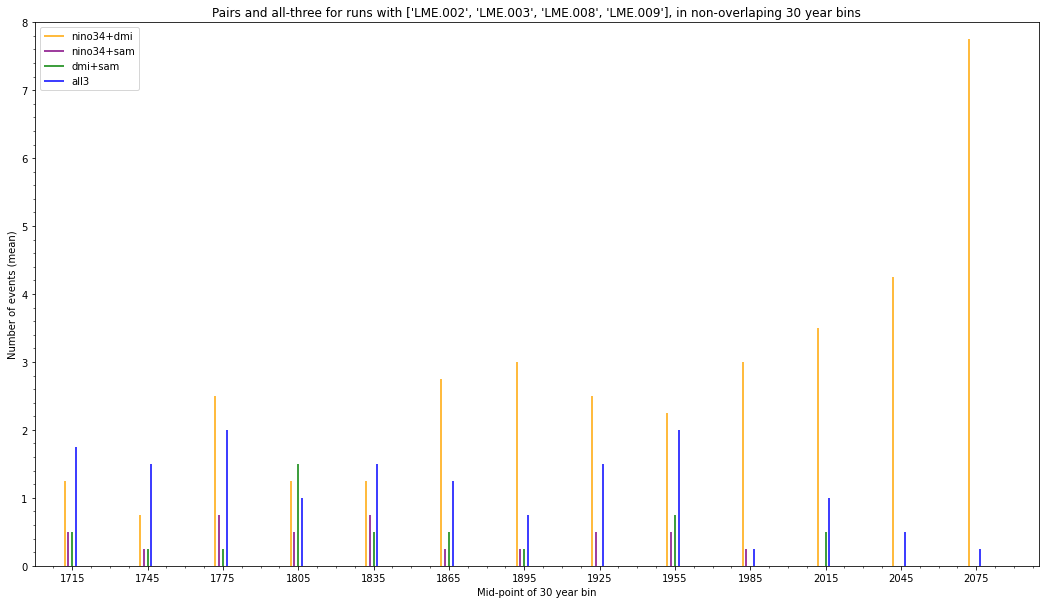

In [22]:
binPlot(binnedFirePos.where(binnedFirePos.year<=1985, drop=True), _model.cesmFullForcings)

binPlot(binnedFirePos, _model.cesmRcp85)

# In overlapping 30 year bins

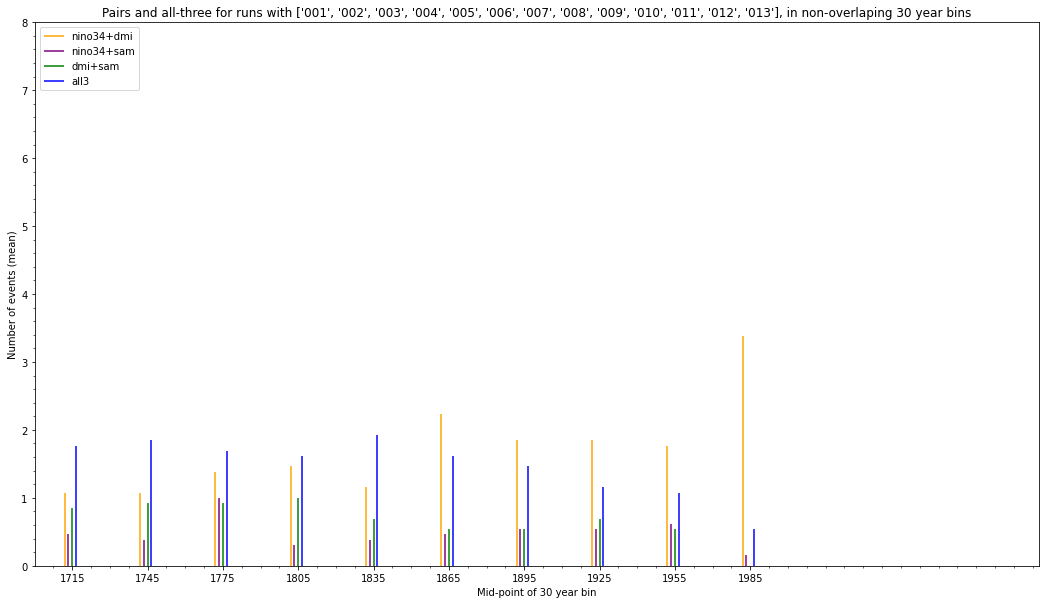

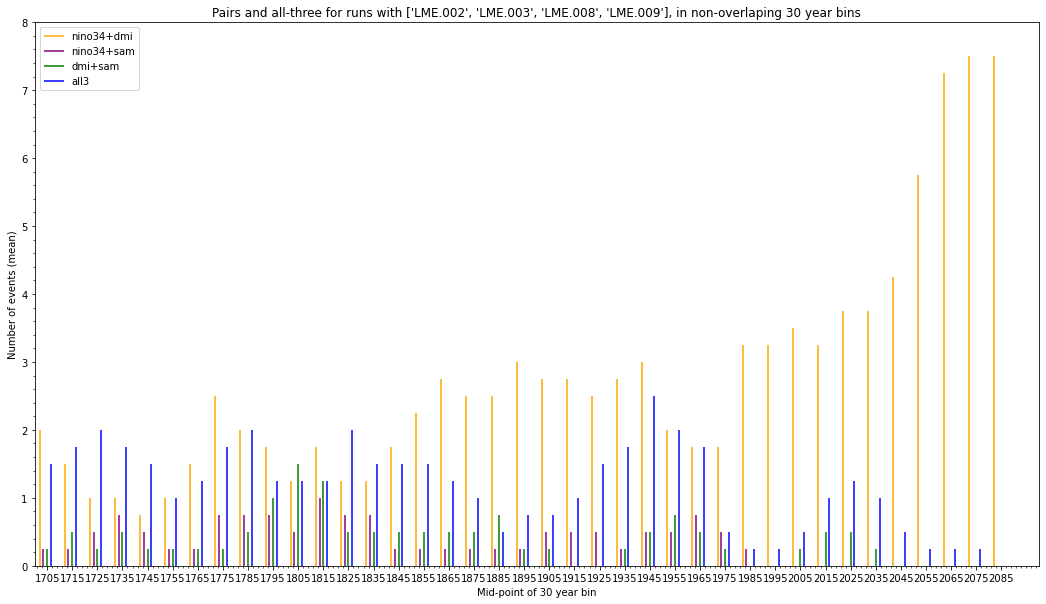

In [23]:
overBinFirePos = overlappingBinSum(firePos)

binPlot(overBinFirePos.where(binnedFirePos.year<=1985, drop=True), _model.cesmFullForcings)

binPlot(overBinFirePos, _model.cesmRcp85)